## Dataset preparation

In [1]:
import numpy as np
import pandas as pd
results_path = 'D:/PSED/Results/Jarvis_term_1000_cleaned/'
data_downselect = pd.read_pickle('D:/PSED/Jarvis_cfid/data_downselect.pkl')
# cgcnn_features_all = pd.read_pickle('D:/PSED/Jarvis_cfid/cgcnn_features_sorted.pkl').feature
descriptors_all = pd.read_pickle('D:/PSED/Jarvis_features.pkl').drop(columns=['Compound'])
descriptors = descriptors_all.drop(columns=descriptors_all.columns[np.where(descriptors_all.var() == 0)])

# cgcnn_features_test = pd.Series([np.asarray(row) for row in cgcnn_features], index=data_downselect.index)

In [2]:
data_l = pd.read_pickle(results_path + 'data_l.pkl')
data_test = pd.read_pickle(results_path + 'data_test.pkl')
sample_path = np.load(results_path + 'sample_path.npy').astype(int)
samples = sample_path[sample_path != 0]
data_u = data_downselect.drop(index=data_l.index.union(data_test.index), inplace=False)

samples_etal = data_downselect.loc[samples]
samples_rand = data_u.sample(n=samples.shape[0], random_state=42)
data_l_etal = pd.concat([data_l, samples_etal])
data_l_rand = pd.concat([data_l, samples_rand])

In [3]:
x_etal= descriptors.loc[data_l_etal.index]
x_rand = descriptors.loc[data_l_rand.index]
x_test = descriptors.loc[data_test.index]

B_etal = data_downselect.loc[data_l_etal.index]['bulk_modulus_kv']
B_rand = data_downselect.loc[data_l_rand.index]['bulk_modulus_kv']
B_test = data_downselect.loc[data_test.index]['bulk_modulus_kv']

G_etal = data_downselect.loc[data_l_etal.index]['shear_modulus_gv']
G_rand = data_downselect.loc[data_l_rand.index]['shear_modulus_gv']
G_test = data_downselect.loc[data_test.index]['shear_modulus_gv']

## SVM

In [170]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
svm_etal = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
svm_rand = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
svm_etal.fit(x_etal, B_etal)
svm_rand.fit(x_rand, B_rand)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)), ('svr', SVR(C=10))])

In [173]:
n_rep = 10
def train_svr_etal_B(i):
    svr_etal_B = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
    svr_etal_B.fit(x_etal, B_etal)
    return svr_etal_B.score(x_test, B_test)

def train_svr_rand_B(i):
    svr_rand_B = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
    svr_rand_B.fit(x_rand, B_rand)
    return svr_rand_B.score(x_test, B_test)

svr_r2_etal_B = Parallel(n_jobs=10)(delayed(train_svr_etal_B)(i) for i in range (n_rep))
svr_r2_rand_B = Parallel(n_jobs=10)(delayed(train_svr_rand_B)(i) for i in range (n_rep))
print(np.mean(svr_r2_etal_B) - np.mean(svr_r2_rand_B))

-0.009732112011510363


## AdaBoost

In [4]:
from sklearn.ensemble import AdaBoostRegressor
n_rep = 30
ab_r2_etal_G = np.zeros(n_rep)
ab_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    ab_etal_G = AdaBoostRegressor(random_state=i).fit(x_etal, G_etal)
    ab_rand_G = AdaBoostRegressor(random_state=i).fit(x_rand, G_rand)
    ab_r2_rand_G[i] = ab_rand_G.score(x_test, G_test)
    ab_r2_etal_G[i] = ab_etal_G.score(x_test, G_test)

In [8]:
ab_r2_etal_B = np.zeros(n_rep)
ab_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    ab_etal_B = AdaBoostRegressor(random_state=i).fit(x_etal, B_etal)
    ab_rand_B = AdaBoostRegressor(random_state=i).fit(x_rand, B_rand)
    ab_r2_rand_B[i] = ab_rand_B.score(x_test, B_test)
    ab_r2_etal_B[i] = ab_etal_B.score(x_test, B_test)

In [10]:
ab_r2_etal_B

array([0.66125935, 0.64095463, 0.66704044, 0.65949265, 0.66705016,
       0.66656343, 0.65996321, 0.63976381, 0.65936106, 0.66895742,
       0.66010996, 0.66270906, 0.67862342, 0.66036546, 0.66726056,
       0.6562295 , 0.67406286, 0.6615827 , 0.68742404, 0.63622619,
       0.67173378, 0.66252194, 0.61642583, 0.65979594, 0.67433429,
       0.6514084 , 0.67031732, 0.64678042, 0.68991746, 0.66140884])

## Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
n_rep = 30
rf_r2_etal_G = np.zeros(n_rep)
rf_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    rf_etal_G = RandomForestRegressor(random_state=i).fit(x_etal, G_etal)
    rf_rand_G = RandomForestRegressor(random_state=i).fit(x_rand, G_rand)
    rf_r2_rand_G[i] = rf_rand_G.score(x_test, G_test)
    rf_r2_etal_G[i] = rf_etal_G.score(x_test, G_test)

In [80]:
rf_r2_etal_B = np.zeros(n_rep)
rf_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    rf_etal_B = RandomForestRegressor(random_state=i).fit(x_etal, B_etal)
    rf_rand_B = RandomForestRegressor(random_state=i).fit(x_rand, B_rand)
    rf_r2_rand_B[i] = rf_rand_B.score(x_test, B_test)
    rf_r2_etal_B[i] = rf_etal_B.score(x_test, B_test)

## Gradient Boost

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
n_rep = 30
gb_r2_etal_G = np.zeros(n_rep)
gb_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    gb_etal_G = GradientBoostingRegressor(random_state=i).fit(x_etal, G_etal)
    gb_rand_G = GradientBoostingRegressor(random_state=i).fit(x_rand, G_rand)
    gb_r2_rand_G[i] = gb_rand_G.score(x_test, G_test)
    gb_r2_etal_G[i] = gb_etal_G.score(x_test, G_test)

In [45]:
gb_r2_etal_B = np.zeros(n_rep)
gb_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    gb_etal_B = GradientBoostingRegressor(random_state=i).fit(x_etal, B_etal)
    gb_rand_B = GradientBoostingRegressor(random_state=i).fit(x_rand, B_rand)
    gb_r2_rand_B[i] = gb_rand_B.score(x_test, B_test)
    gb_r2_etal_B[i] = gb_etal_B.score(x_test, B_test)

## Neural Net

In [43]:
from sklearn.neural_network import MLPRegressor
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
n_rep = 30
hidden_size = (128,)
batch_size = 32
max_iter = 500
alpha = 0.1
# learning_rate_init = 0.001
activation = 'relu'

def train_nn_etal_B(i):
    nn_etal_B = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_etal_B.fit(x_etal, B_etal)
    return nn_etal_B.score(x_test, B_test)

def train_nn_rand_B(i):
    nn_rand_B = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_rand_B.fit(x_rand, B_rand)
    return nn_rand_B.score(x_test, B_test)

nn_r2_etal_B = Parallel(n_jobs=10)(delayed(train_nn_etal_B)(i) for i in range (n_rep))
nn_r2_rand_B = Parallel(n_jobs=10)(delayed(train_nn_rand_B)(i) for i in range (n_rep))


def train_nn_etal_G(i):
    
    nn_etal_G = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_etal_G.fit(x_etal, G_etal)
    return nn_etal_G.score(x_test, G_test)

def train_nn_rand_G(i):
    nn_rand_G = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_rand_G.fit(x_rand, G_rand)
    return nn_rand_G.score(x_test, G_test)

nn_r2_etal_G = Parallel(n_jobs=10)(delayed(train_nn_etal_G)(i) for i in range (n_rep))
nn_r2_rand_G = Parallel(n_jobs=10)(delayed(train_nn_rand_G)(i) for i in range (n_rep))

np.mean(nn_r2_etal_G)-np.mean(nn_r2_rand_G), np.mean(nn_r2_etal_B)-np.mean(nn_r2_rand_B)


(0.01653454377793251, 0.0028510784907186393)

In [44]:
np.mean(nn_r2_etal_G), np.mean(nn_r2_etal_B)

(0.5879047730731908, 0.7495866165015)

Grid CV search for SVM

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svr = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('svr', SVR())])
parameters = {'svr__kernel':('rbf', 'poly', 'sigmoid'), 'svr__C': [1,5,10], 'pca__n_components': [3,5,7,9]}
clf = GridSearchCV(svr, parameters)
clf.fit(x_etal, B_etal)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svr', SVR())]),
             param_grid={'pca__n_components': [3, 5, 7, 9],
                         'svr__C': [1, 5, 10],
                         'svr__kernel': ('rbf', 'poly', 'sigmoid')})

Grid CV search for NN

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
nn = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(early_stopping=True, max_iter=500, batch_size=32))])
parameters = {'mlp__alpha': [0.01, 0.05, 0.1],
              'mlp__activation': ('tanh', 'relu'),
              'mlp__hidden_layer_sizes': ((128,), (64,64), (128,128))
             }
clf = GridSearchCV(nn, parameters, verbose=3, n_jobs=-1)
clf.fit(x_etal, B_etal)
clf.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'mlp__activation': 'tanh',
 'mlp__alpha': 0.1,
 'mlp__hidden_layer_sizes': (128,)}

## Make plot

In [69]:
import seaborn as sns


In [97]:
results = pd.concat([pd.DataFrame({'r2': gb_r2_etal_B, 'model': 'gb-B', 'target': 'B', 'dataset':'etal'}),
                     pd.DataFrame({'r2': gb_r2_etal_G, 'model': 'gb-G', 'target': 'G', 'dataset':'etal'}),
                     pd.DataFrame({'r2': rf_r2_etal_B, 'model': 'rf-B', 'target': 'B', 'dataset':'etal'}),
                     pd.DataFrame({'r2': rf_r2_etal_G, 'model': 'rf-G', 'target': 'G', 'dataset':'etal'}),
                     pd.DataFrame({'r2': gb_r2_rand_B, 'model': 'gb-B', 'target': 'B', 'dataset':'rand'}),
                     pd.DataFrame({'r2': gb_r2_rand_G, 'model': 'gb-G', 'target': 'G', 'dataset':'rand'}),
                     pd.DataFrame({'r2': rf_r2_rand_B, 'model': 'rf-B', 'target': 'B', 'dataset':'rand'}),
                     pd.DataFrame({'r2': rf_r2_rand_G, 'model': 'rf-G', 'target': 'G', 'dataset':'rand'}),
                    ], ignore_index=True)
results.to_pickle('D:/PSED/Results/ML/ML_r2.pkl')

In [56]:
results_ens = pd.read_pickle('D:/PSED/Results/ML/ML_r2.pkl')
results = pd.concat([results_ens,
                     pd.DataFrame({'r2': nn_r2_etal_B, 'model': 'nn-B', 'target': 'B', 'dataset': 'etal'}),
                     pd.DataFrame({'r2': nn_r2_etal_G, 'model': 'nn-G', 'target': 'G', 'dataset': 'etal'}),
                     pd.DataFrame({'r2': nn_r2_rand_B, 'model': 'nn-B', 'target': 'B', 'dataset': 'rand'}),
                     pd.DataFrame({'r2': nn_r2_rand_G, 'model': 'nn-G', 'target': 'G', 'dataset': 'rand'})
                    ], ignore_index=True)

In [66]:
results.loc[results['model'] == 'gb-B', 'model'] = 'Gradient Boosting'
results.loc[results['model'] == 'gb-G', 'model'] = 'Gradient Boosting'
results.loc[results['model'] == 'rf-B', 'model'] = 'Random Forest'
results.loc[results['model'] == 'rf-G', 'model'] = 'Random Forest'
results.loc[results['model'] == 'nn-B', 'model'] = 'Neural Network'
results.loc[results['model'] == 'nn-G', 'model'] = 'Neural Network'
results.loc[results['dataset'] == 'etal', 'dataset'] = 'ETAL'
results.loc[results['dataset'] == 'rand', 'dataset'] = 'RAND'
results.columns = ['R^2', 'Model', 'Target', 'Dataset']


In [68]:
results.to_pickle('D:/PSED/Results/ML/ML_r2_all.pkl')

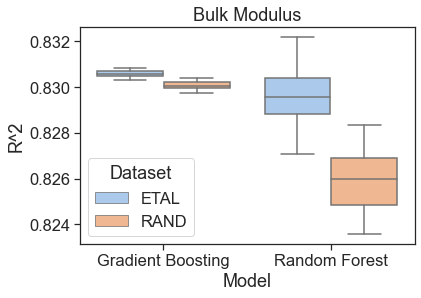

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
results = pd.read_pickle('D:/PSED/Results/ML/ML_r2_all.pkl')
sns.set_theme(style="ticks", palette='pastel', font_scale=1.5)
sns.boxplot(x='Model', y='R^2', hue='Dataset', data=results[(results['Target'] == 'B') & (results['Model'] != 'Neural Network')])


plt.title('Bulk Modulus')
plt.savefig('D:/PSED/plots/r2_B.png', dpi=200, bbox_inches='tight')

In [4]:
results[(results['Target'] == 'B') & (results['Model'] != 'Neural Network')]

,R^2,Model,Target,Dataset
0,0.830714,Gradient Boosting,B,ETAL
1,0.830701,Gradient Boosting,B,ETAL
2,0.830531,Gradient Boosting,B,ETAL
3,0.830475,Gradient Boosting,B,ETAL
4,0.830579,Gradient Boosting,B,ETAL
...,...,...,...,...
205,0.826832,Random Forest,B,RAND
206,0.826403,Random Forest,B,RAND
207,0.823569,Random Forest,B,RAND
208,0.827047,Random Forest,B,RAND


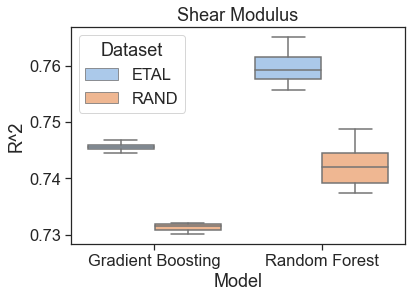

In [75]:
sns.set_theme(style="ticks", palette='pastel', font_scale=1.5)
sns.boxplot(x='Model', y='R^2', hue='Dataset', data=results[(results['Target'] == 'G') & (results['Model'] != 'Neural Network')])
plt.title('Shear Modulus')
plt.savefig('D:/PSED/plots/r2_G.png', dpi=200, bbox_inches='tight')